# Progetto BigData
## Valerio Di Zio e Francesco Magnani

In [1]:
%%configure -f
{"executorMemory":"8G", "numExecutors":2, "executorCores":3, "driverMemory": "2g"}

In [2]:
val bucketname = "unibo-bd2324-fmagnani"

val path_book_sample = "s3a://"+bucketname+"/project/book_sample134.json"
val path_book_sample_7gb = "s3a://"+bucketname+"/project/books_sample7gb.json"
val path_positive_words = "s3a://"+bucketname+"/project/positive-words.txt"
val path_negative_words = "s3a://"+bucketname+"/project/negative-words.txt"

"SPARK UI: Enable forwarding of port 20888 and connect to http://localhost:20888/proxy/" + sc.applicationId + "/"

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
0,application_1708622988219_0001,spark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

bucketname: String = unibo-bd2324-fmagnani
path_book_sample: String = s3a://unibo-bd2324-fmagnani/project/book_sample134.json
path_book_sample_7gb: String = s3a://unibo-bd2324-fmagnani/project/books_sample7gb.json
path_positive_words: String = s3a://unibo-bd2324-fmagnani/project/positive-words.txt
path_negative_words: String = s3a://unibo-bd2324-fmagnani/project/negative-words.txt
res3: String = SPARK UI: Enable forwarding of port 20888 and connect to http://localhost:20888/proxy/application_1708622988219_0001/


In [3]:
import org.apache.spark.rdd.RDD
import org.apache.spark.sql.DataFrame
import org.apache.spark.broadcast.Broadcast

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

import org.apache.spark.rdd.RDD
import org.apache.spark.sql.DataFrame
import org.apache.spark.broadcast.Broadcast


In [4]:
case class BookReview(
    id: String,
    overall:Double,
    reviewTime:String,
    reviewerID:String,
    asin:String,
    reviewText:String,
    summary:String
)

object BookReview{
    def extract(row:org.apache.spark.sql.Row) = {
        val overall = row.getAs[Double]("overall")
        val reviewTime = row.getAs[String]("reviewTime")
        val reviewerID = row.getAs[String]("reviewerID")
        val asin = row.getAs[String]("asin")
        val reviewText = row.getAs[String]("reviewText")
        val summary = row.getAs[String]("summary")
        val id = reviewerID + "-" + asin
    
        new BookReview(id, overall, reviewTime, reviewerID, asin, reviewText, summary)
    }
}

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

defined class BookReview
defined object BookReview
Companions must be defined together; you may wish to use :paste mode for this.


## Caricamento del Dataset
Il dataset utilizzato è di tipo json, per l'import utilizziamo la funzione ``spark.read`` nello specifico con l'opzione _"dropmalformed"_ che ci permette di evitare eventuali problemi nel dataset.
Il dataset utilizzato ha una dimensione di ~ 7GB

In [5]:
// È possibile decommentare la linea di codice seguente per utilizzare un dataset di dimensioni ridotte (128MB).
//val bookDataset = spark.read.option("mode", "DROPMALFORMED").json(path_book_sample).map(BookReview.extract)

val bookDataset = spark.read.option("mode", "DROPMALFORMED").json(path_book_sample_7gb).map(BookReview.extract)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

bookDataset: org.apache.spark.sql.Dataset[BookReview] = [id: string, overall: double ... 5 more fields]


# Job1 - Sentiment Analysis
### Descrizione del Problema
L'analisi dei sentimenti è una tecnica utilizzata per determinare il sentimento associato a un certo testo, che può essere positivo, negativo o neutro. 
Nel contesto delle recensioni di prodotti su Amazon, l'analisi dei sentimenti può essere di grande valore per comprendere il feedback dei clienti e identificare le opinioni predominanti su un determinato prodotto.

Questo notebook affronta il problema dell'analisi dei sentimenti sulle recensioni di libri venduti su Amazon utilizzando l'approccio delle Word List:

Liste di Parole Positive e Negative: Questo metodo si basa sull'utilizzo di liste di parole positive e negative predefinite. Ogni parola nella recensione viene confrontata con le parole presenti nelle liste positive e negative per determinare il sentiment complessivo della recensione.

Nel seguente notebook, esploreremo come implementare l'analisi dei sentimenti utilizzando liste di parole positive e negative, fornendo un esempio pratico di come applicare questo approccio per valutare il sentiment di una recensione di libri su Amazon. Successivamente verrà calcolato l'errore confrontando i voti predetti con i voti effettivi.

### Creazione delle liste di parole positive e negaive

In [6]:
val positiveWords = sc.textFile(path_positive_words)
val negativeWords = sc.textFile(path_negative_words)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

positiveWords: org.apache.spark.rdd.RDD[String] = s3a://unibo-bd2324-fmagnani/project/positive-words.txt MapPartitionsRDD[5] at textFile at <console>:27
negativeWords: org.apache.spark.rdd.RDD[String] = s3a://unibo-bd2324-fmagnani/project/negative-words.txt MapPartitionsRDD[7] at textFile at <console>:27


### Split and Clean
Definiamo la funzione ``splitAndClean()`` che accetta come parametro l'id della recensione con il suo testo.
Restituendo un array dove l'id verrà associato ad ogni parola della recensione (split) a cui verrà dato come peso il valore 1, che permetterà di aumentare o diminuire il punteggio assegnato alla frase.

In [7]:
def splitAndClean(id:String, text: String): Array[(String, String, Int)] = 
    text.split("\\s+").map(el => (id, el.toLowerCase.replaceAll("[^a-zA-Z\\s]", ""), 1))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

splitAndClean: (id: String, text: String)Array[(String, String, Int)]


## Ottimizzazione Job 1
Il processo di ottimizzazione non è stato immediato, inizialmente abbiamo pensato di implementare una versione semplice dell'applicativo, utilizzando un dataset di dimensioni ridotte su cui poter testare la logica.
Successivamente sono state applicate 2 ottimizzazioni principali:

1. Utilizzo di variabili broadcast per le liste di parole uguali per tutti
2. Utilizzo di meccanismi di cache
3. Ottimizzazione delle strutture dati per evitare conversioni inutili di tipi

## Job 1 - Prima fase, conta delle parole

All'interno del blocco di codice che segue vi è il core dell'elaborazione.

Sono state definite delle funzioni che si occupano di contare il numero di occorrenze di una parola in una determinata frase e di ottenere un risultato nella forma: ```("id frase", "numero parole positive" o "numero parole negative")```.
Al risultato ottenuto viene applicato un join con opportuna sottrazione (positive - negative) ottenendo così un "peso" che verrà utilizzato successivamente per capire se una frase esprime un sentimento positivo o negativo.

In [8]:

def countOccurrenciesOfWordReview(reviews: DataFrame): DataFrame = 
    reviews.
        groupBy("id", "word").
        agg(sum("occurrencies").alias("occurrencies"))


def joinAndMapWords(review:DataFrame, wordsDataset: Broadcast[Array[String]]): DataFrame = {
    val wordDF = review.sparkSession.createDataFrame(wordsDataset.value.map(Tuple1.apply)).toDF("word")
    
    val aggregRevDF = countOccurrenciesOfWordReview(review)
    
    return aggregRevDF.
        join(wordDF, aggregRevDF("word") === wordDF("word")).
        groupBy("id").
        agg(sum("occurrencies").alias("occurrencies"))
}

    

val reviewsDataset = bookDataset.
    select("id", "reviewText").
    dropDuplicates(Seq("id")).
    filter(review => review.getAs[String]("reviewText") != null && review.getAs[String]("reviewText").length > 3).
    flatMap(review => splitAndClean(review.getAs[String]("id"), review.getAs[String]("reviewText"))).
    filter(row => row._2.length > 3).
    toDF("id", "word", "occurrencies").
    cache()

val positiveWordsBroadcast = sc.broadcast(positiveWords.collect())
val negativeWordsBroadcast = sc.broadcast(negativeWords.collect())


val withPositiveDF = joinAndMapWords(reviewsDataset, positiveWordsBroadcast)
    
val withNegativeDF = joinAndMapWords(reviewsDataset, negativeWordsBroadcast)


val reducedResult = withPositiveDF.
    join(withNegativeDF, Seq("id"), "outer").
    toDF("id", "valuePositive", "valueNegative").
    withColumn("weight", coalesce(col("valuePositive"), lit(0L)) - coalesce(col("valueNegative"), lit(0L)))
     

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

countOccurrenciesOfWordReview: (reviews: org.apache.spark.sql.DataFrame)org.apache.spark.sql.DataFrame
joinAndMapWords: (review: org.apache.spark.sql.DataFrame, wordsDataset: org.apache.spark.broadcast.Broadcast[Array[String]])org.apache.spark.sql.DataFrame
reviewsDataset: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [id: string, word: string ... 1 more field]
positiveWordsBroadcast: org.apache.spark.broadcast.Broadcast[Array[String]] = Broadcast(5)
negativeWordsBroadcast: org.apache.spark.broadcast.Broadcast[Array[String]] = Broadcast(7)
withPositiveDF: org.apache.spark.sql.DataFrame = [id: string, occurrencies: bigint]
withNegativeDF: org.apache.spark.sql.DataFrame = [id: string, occurrencies: bigint]
reducedResult: org.apache.spark.sql.DataFrame = [id: string, valuePositive: bigint ... 2 more fields]


# Job 1 - Seconda fase, calcolo dei risultati 

Successivamente calcoliamo il risultato ottenuto utilizzando una normalizzazione Z-Score, successivamente normalizzata a sua volta tramite Min-Max tra 1 e 5 così da ottenere un voto confrontabile con il metodo utilizzato da Amazon, le stelle che possono essere 1,2,3,4 o 5.
Il valore così ottenuto viene poi confrontato con quello presente nel dataset (overall), per verificare la correttezza delle nostre previsioni calcolando un errore.

Durante l'analisi è sorto un problema di dati *outliers* che ha causato un'anomalia nella normalizzazione dei dati, portando ad una stima dell'errore medio poco precisa. Eliminando una porzione dei dati, scartando quelli con peso eccessivamente alto o eccessivamente basso la normalizzazione risulta più bilanciata e l'errore più contenuto. Per far ciò, abbiamo utilizzato due soglie.

In [9]:
val MIN_TRESHOLD = -10
val MAX_TRESHOLD = 10

val resultDataframeRaw = reducedResult.select("id", "weight").cache()
val resultDataframe = resultDataframeRaw.filter( ($"weight" < MAX_TRESHOLD) && ($"weight" > MIN_TRESHOLD))

// Calculate mean and standard deviation

val meanAndStdDF = resultDataframe.agg(mean("weight"), stddev("weight")).collect()
val meanValue = meanAndStdDF(0)(0).asInstanceOf[Double]
val stdValue = meanAndStdDF(0)(1).asInstanceOf[Double]

// Normalize the data using Z-score normalization formula

val normalizedDF = resultDataframe.withColumn("z_score", (col("weight") - meanValue) / stdValue)

// Scale the normalized values to be between -1 and 1
val minMaxDF = normalizedDF.agg(min("z_score"), max("z_score")).collect()
val minZScore = minMaxDF(0)(0).asInstanceOf[Double]
val maxZScore = minMaxDF(0)(1).asInstanceOf[Double]


val normalizedAndScaledDF = normalizedDF.withColumn("estimated_overall", 
                                                    (col("z_score") - minZScore) / (maxZScore - minZScore) * 4 + 1).
    select("id", "estimated_overall")
    

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

MIN_TRESHOLD: Int = -10
MAX_TRESHOLD: Int = 10
resultDataframeRaw: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [id: string, weight: bigint]
resultDataframe: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [id: string, weight: bigint]
meanAndStdDF: Array[org.apache.spark.sql.Row] = Array([1.7176823885475228,2.577777605910873])
meanValue: Double = 1.7176823885475228
stdValue: Double = 2.577777605910873
normalizedDF: org.apache.spark.sql.DataFrame = [id: string, weight: bigint ... 1 more field]
minMaxDF: Array[org.apache.spark.sql.Row] = Array([-4.1577218934526226,2.8250371927950813])
minZScore: Double = -4.1577218934526226
maxZScore: Double = 2.8250371927950813
normalizedAndScaledDF: org.apache.spark.sql.DataFrame = [id: string, estimated_overall: double]


In [10]:
println("Percentuale di elementi scartati: "+(resultDataframeRaw.count().toDouble - resultDataframe.count()) / resultDataframe.count() * 100 + " %")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Percentuale di elementi scartati: 4.315023709934394 %


## Visualizzazione dei valori calcolati sul Dataset

Nei grafici seguenti è possibile osservare la distribuzione delle frequenze sulla base dei pesi assegnati alle frasi (calcolati combinando numero di parole positive e negative). 
Il secondo grafico è riportato in scala logaritmica per migliore visualizzazione.

Qui è possibile notare la presenza degli *outliers* precedentemente discussi.

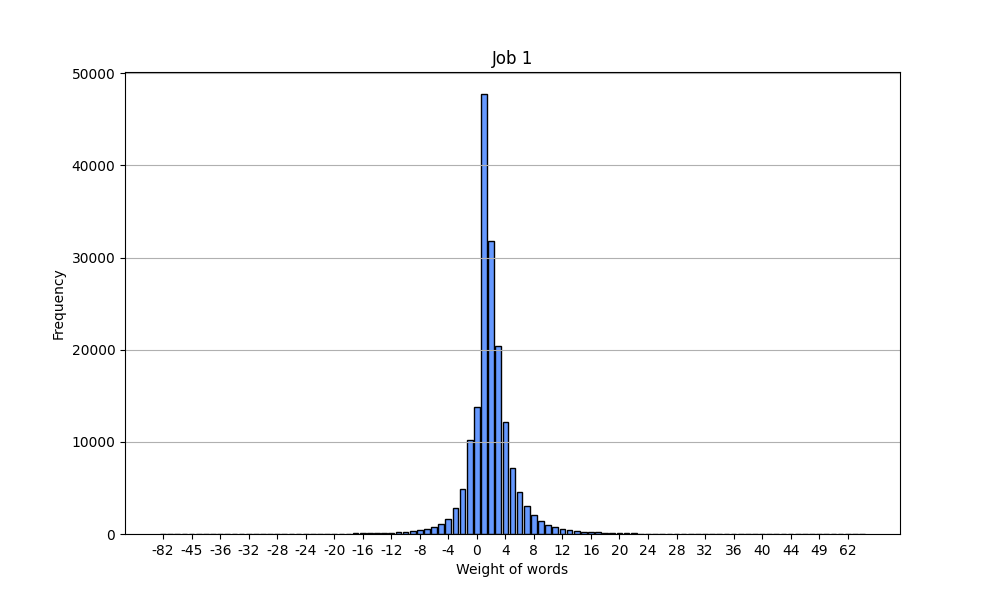


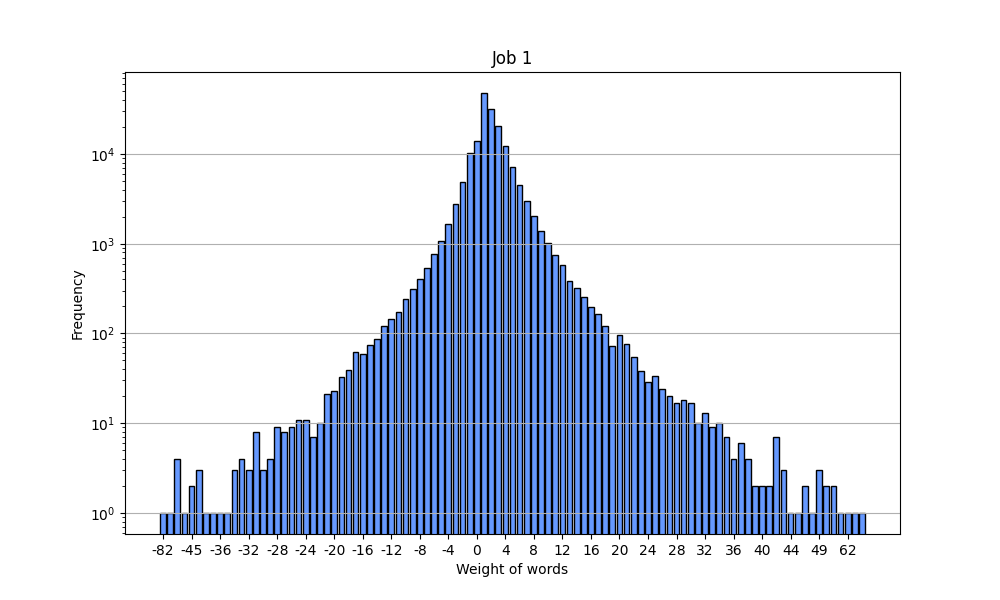

In [11]:
val relativeErrors = 
bookDataset.
    map(review => (review.id, review.overall)).
    toDF("id", "real_value").
    join(normalizedAndScaledDF, Seq("id")).
    withColumn("relative_error", abs(coalesce(col("real_value"), lit(3.0)) - 
                                     coalesce(col("estimated_overall"), lit(3.0))) / 
                                   coalesce(col("real_value"), lit(3.0)))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

relativeErrors: org.apache.spark.sql.DataFrame = [id: string, real_value: double ... 2 more fields]


In [12]:
val sumOfRelativeErrors = relativeErrors.select("relative_error").agg(sum("relative_error")).
                                collect()(0).getDouble(0)
val meanError =  sumOfRelativeErrors / relativeErrors.count

println("Errore Medio: " + meanError*100 + "%")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

sumOfRelativeErrors: Double = 3182696.1425818047
meanError: Double = 0.34907346231037456
Errore Medio: 34.90734623103746%


# Job 2 - Frequent Pattern Mining

Qui inizia il secondo Job, dove effettuiamo un Frequent Pattern Mining utilizzando le funzionalità di Spark.

## Creazione del DataFrame delle reviews
Prima di tutto andiamo a definire una funzione di utility che ci permette di eliminare eventuali caratteri estranei dai testi delle recensioni (es. virgole, punti etc.). 

Dopodiché, utilizziamo il Dataset caricato anche per il primo Job e ne prendiamo solo le colonne `"id"` e `"reviewText"`, sono le uniche che ci servono. In modo simile al primo Job, eliminiamo le recensioni duplicate usando ```dropDuplicates```: questo è necessario perché esplorando il Dataset sono state trovate recensioni identiche per lo stesso prodotto, facenti riferimento a diverse versioni dello stesso.

Per comodità, il Dataset viene convertito in un RDD in modo da svolgere le successive operazioni di **filter** e **map**. Infine, otteniamo il risultato in forma di DataFrame.

In [13]:
def clean(text: String): String =
    text.toLowerCase.replaceAll("[^a-zA-Z\\s]", " ")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

clean: (text: String)String


In [14]:
val reviewsDF = bookDataset.
    select("id", "reviewText").
    dropDuplicates(Seq("id")).
    map(review => (review.getAs[String]("id"), review.getAs[String]("reviewText"))).
    rdd.
    filter({case (_, text) => text != null && text.length > 3}).
    map({case (id, text) => (id, clean(text))}).
    toDF("id", "text").
    cache()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

reviewsDF: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [id: string, text: string]


## Creazione di Tokenizer e StopWord remover

Queste due funzioni sono utili per **dividere i testi in parole** e **rimuovere le stop words** (parole comunemente utilizzate in un linguaggio ma normalmente prive di valore se prese da sole, per esempio "is", "the" etc.)

In [15]:
import org.apache.spark.ml.feature.{Tokenizer, StopWordsRemover}

val tokenizer = new Tokenizer().
    setInputCol("text").
    setOutputCol("words")

val remover = new StopWordsRemover().
    setInputCol("words").
    setOutputCol("filtered_words")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

import org.apache.spark.ml.feature.{Tokenizer, StopWordsRemover}
tokenizer: org.apache.spark.ml.feature.Tokenizer = tok_e446bda3166f
remover: org.apache.spark.ml.feature.StopWordsRemover = StopWordsRemover: uid=stopWords_4d02c364f6ca, numStopWords=181, locale=en_US, caseSensitive=false


## Pulizia del Dataset

Nella cella seguente andiamo a utilizzare il `tokenizer` e il `remover` creati precedentemente per pulire ulteriormente il DataFrame. 

Osservando i risultati di `filteredWordsDF` si può notare che sono ancora presenti refusi e stringhe contenenti spazi. Oltre a questo, la classe che verrà utilizzata successivamente, ovvero `FPGrowth`, richiede che all'interno di ogni pattern siano presenti stringhe **univoche**, motivo per cui andiamo a svolgere l'operazione `toArray.distinct`, che rimuove elementi duplici all'interno di un'Array di Scala)

Otteniamo, infine, un DataFrame da una sola colonna, contenente un Array di parole per ciascuna recensione. È possibile notare che non sono più presenti gli ID: questi infatti non sono più necessari al fine di computare i Frequent Pattern.

In [16]:
import scala.collection.mutable.WrappedArray

val wordsDF = tokenizer.transform(reviewsDF)
val filteredWordsDF = remover.transform(wordsDF)

val uniqueWordsDF = filteredWordsDF.
    select("filtered_words").
    distinct().
    map(item => item.getAs[WrappedArray[String]](0).filter(_.length > 1).toArray.distinct).
    toDF("words")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

import scala.collection.mutable.WrappedArray
wordsDF: org.apache.spark.sql.DataFrame = [id: string, text: string ... 1 more field]
filteredWordsDF: org.apache.spark.sql.DataFrame = [id: string, text: string ... 2 more fields]
uniqueWordsDF: org.apache.spark.sql.DataFrame = [words: array<string>]


## Utilizzo di FPGrowth

Nella cella seguente definiamo una funzione che ci permette di utilizzare facilmente la classe di `FPGrowth` per calcolare i Frequent Pattern di un DataFrame. Questa istanzia la classe in questione, fissando gli iper-parametri a dei valori arbitrari: in particolare, il **supporto minimo** per considerare un pattern *frequent* e la **confidenza minima**, ovvero (dalla documentazione di Spark) un'indicazione di quanto spesso una *association rule* viene trovata vera. Quest'ultima non influenza la ricerca dei Frequent Pattern.

In [17]:
import org.apache.spark.ml.fpm.FPGrowth

def frequentItemsets(df: DataFrame): DataFrame = {
    val fpg = new FPGrowth().
        setItemsCol("words").
        setMinSupport(0.1).
        setMinConfidence(0.5)

    val model = fpg.fit(df)
    return model.freqItemsets
}


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

import org.apache.spark.ml.fpm.FPGrowth
frequentItemsets: (df: org.apache.spark.sql.DataFrame)org.apache.spark.sql.DataFrame


## Visualizzazione dei risultati

Se effettuiamo una prima visualizzazione dei risultati è possibile notare fin da subito come i risultati più frequenti siano parole come "libro" e "leggere", risultati piuttosto predicibili. 
Andiamo quindi a creare un nuovo dataset applicando una blacklist, ovvero parole da escludere.

## Secondo Dataset, rimuovendo parole triviali (es. "book", "read" etc.)

Per eliminare queste parole dalla ricerca, effettuiamo un'ultima modifica al nostro DataFrame, eliminando parole triviali come "libro" e "leggere", prese da un file opportunamente creato per lo scopo. Questo viene poi tramutato in un array contenuto in una **broadcast variable**. Infine, ogni array di parole viene modificato in modo da sottrarre queste parole alla ricerca.


In [18]:
// caricamento della blacklist delle parole da escludere
val path_blacklist_words = "s3a://"+bucketname+"/project/blacklist.txt"

val blacklistWords = sc.broadcast(sc.textFile(path_blacklist_words).collect)

val prunedDF = uniqueWordsDF.
    map(item => item.getAs[WrappedArray[String]](0).toArray.filterNot(blacklistWords.value.contains)).
    toDF("words")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

path_blacklist_words: String = s3a://unibo-bd2324-fmagnani/project/blacklist.txt
blacklistWords: org.apache.spark.broadcast.Broadcast[Array[String]] = Broadcast(42)
prunedDF: org.apache.spark.sql.DataFrame = [words: array<string>]


## Utilizzo di FPGrowth sul DataFrame ottenuto

Il risultato finale appare più interessante. Questo potrebbe essere ulteriormente migliorato escludendo più parole dalla ricerca.  

In [19]:
val result = frequentItemsets(prunedDF)
result.show(20)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

result: org.apache.spark.sql.DataFrame = [items: array<string>, freq: bigint]
+------------+-------+
|       items|   freq|
+------------+-------+
|     [story]|2109146|
|     [great]|1770195|
|      [like]|1712180|
|      [good]|1706839|
|      [well]|1433691|
|      [time]|1360297|
|      [love]|1360090|
|[characters]|1279578|
|    [really]|1246523|
|      [much]|1219331|
|     [first]|1151080|
|      [life]|1095586|
|      [many]|1022735|
|       [get]|1021290|
|       [way]|1020689|
|    [author]| 966247|
|      [even]| 953890|
|      [also]| 943279|
|   [written]| 941698|
+------------+-------+



## Visualizzazione dei Frequent Itemsets

Nel grafico seguente è possibile osservare i risultati della Frequent Itemsets Mining in forma di grafico a barre. 

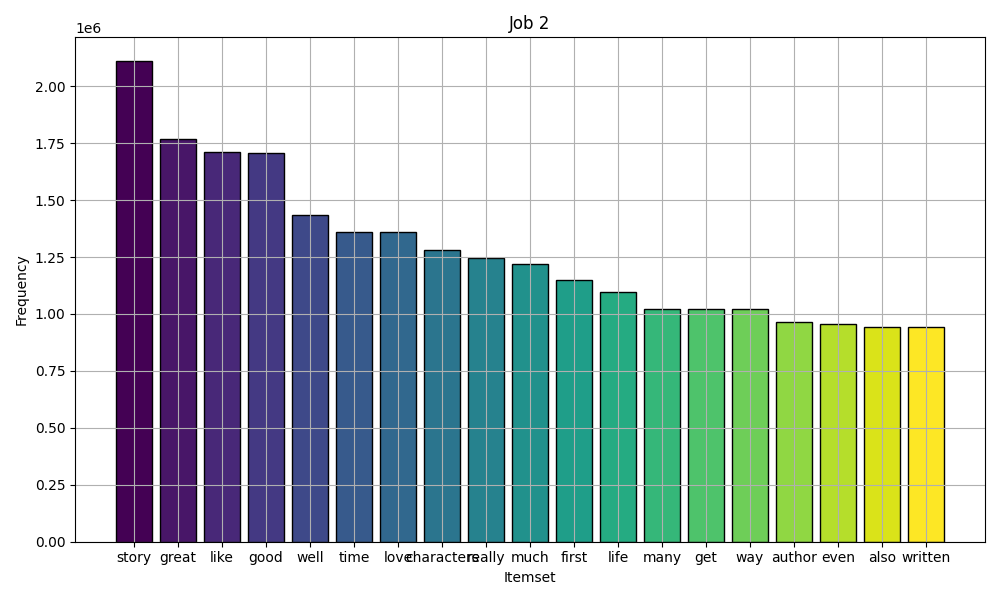